In [22]:
import os
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [23]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
# train_data = datasets.CIFAR10(root="./data", train=True, transform=train_transform, download=False)
# val_data = datasets.CIFAR10(root="./data", train=False, transform=val_transform, download=False)
train_data = datasets.MNIST(root="./data", train=True, transform=train_transform, download=False)
val_data = datasets.MNIST(root="./data", train=False, transform=val_transform, download=False)

In [24]:
train_loader = data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
val_loader = data.DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # 28*28*1 -> 28*28*32
            nn.BatchNorm2d(32),  # 原始不存在
            nn.ReLU(),
            # nn.Conv2d(3,6,5), #32*32*3->28*28*6
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1),  # 28*28*32 -> 28*28*32
            nn.BatchNorm2d(32),  # 原始不存在
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 14*14*32
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),  # 14*14*64
            nn.BatchNorm2d(64),  # 原始不存在
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),  # 14*14*64
            nn.BatchNorm2d(64),  # 原始不存在
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 7*7*16
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),  # 7*7*64
            nn.BatchNorm2d(128),  # 原始不存在
            nn.ReLU(),
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),  # 7*7*128
            nn.BatchNorm2d(128),  # 原始不存在
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 3*3*128
        )
        self.layer7 = nn.Sequential(
            nn.Linear(3 * 3 * 128, 120),
            nn.Linear(120, 84),
            nn.Linear(84, 2, bias=False),
            # nn.LeakyReLU(),
            # nn.ReLU
        )
        self.classifier = nn.Linear(2, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = x.view(x.size(0), -1)  # 展开成batch-size个1维数组
        feature = self.layer7(x)
        output = self.classifier(feature)
        return feature, output

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
model.load_state_dict(torch.load('model_adam0.01_weight_decay0.0005_epoch50.pt'))

In [35]:
def draw(feature, target, epoch):
    color = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
              '#ff00ff', '#990000', '#999900', '#009900', '#009999']
    cls = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    id_to_name = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
    plt.figure(figsize=(10, 10))
    for c in cls:
        mask = (target == c)
        feature_ = feature[mask]
        x = feature_[:, 0]
        y = feature_[:, 1]
        plt.scatter(x, y, color=color[c])
        plt.legend(id_to_name, loc='upper right')
        plt.title("epoch={}".format(epoch))
    plt.show()    

In [36]:
def extract_feature(data_loader, model, device):
    features = []
    targets = []
    model.eval()
    with torch.no_grad():
        for i, (input, target) in enumerate(data_loader):
            input = input.to(device)
            feature, _ = model(input)
            feature = feature.cpu().numpy()
            target = target.numpy()
            features.append(feature)
            targets.append(target)
    return features, targets

In [37]:
train_features, train_targets = extract_feature(train_loader, model, device)

In [38]:
train_featues = np.vstack(train_features)
train_targets = np.hstack(train_targets)

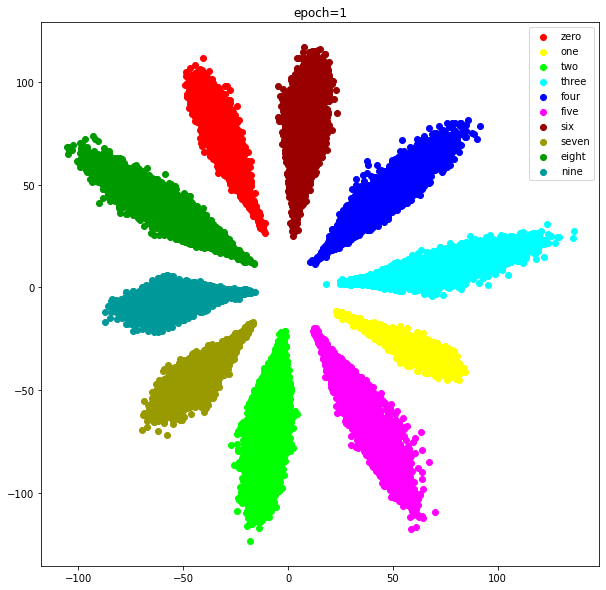

In [39]:
draw(train_featues, train_targets, 1)

In [40]:
val_features, val_targets = extract_feature(val_loader, model, device)

In [41]:
val_features = np.vstack(val_features)
val_targets = np.hstack(val_targets)

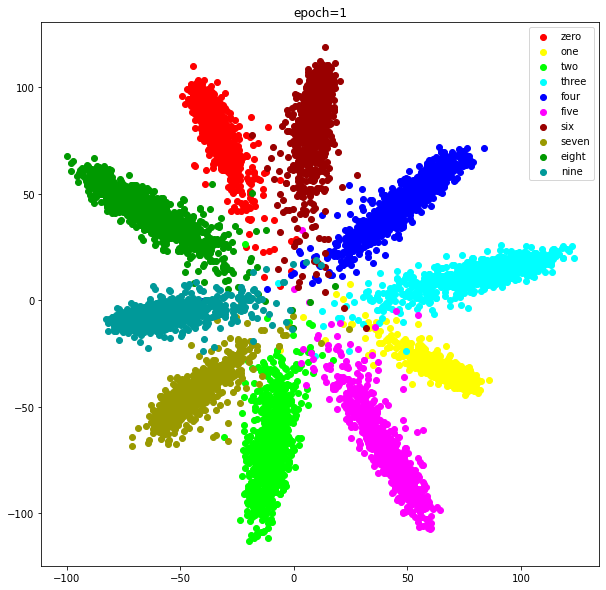

In [42]:
draw(val_features, val_targets, 1)